In [3]:
%%capture
!pip install keras-preprocessing

In [4]:
%%capture
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
from prettytable import PrettyTable
import numpy as np
import pandas as pd
import os

# for dataset splitting and shuffling
import random
import shutil

#For augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from skimage import io
from PIL import Image

#For data generators
import pathlib
import tensorflow as tf

#For convolutional neural network
import tensorflow as tf
from keras.layers.core import Dense
from keras.layers.core import Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint


#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-12-14 04:34:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-14 04:34:41 (77.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from tabulate import tabulate

In [8]:
def TotalImages(path):
    src = os.listdir(path)
    data = []

    for lb in src:
        x = os.path.join(path, lb)
        y = os.listdir(x)
        data.append([lb, len(y)])
         
    # Create the table using tabulate
    table = tabulate(data, headers=["Label", "Number of Images"], tablefmt="fancy_grid")

    # Print the table
    print(table)

In [9]:
dataset_path = "/kaggle/input/sea-animals-image-dataste"

labels = os.listdir(dataset_path)

# Create a new PrettyTable instance
table = PrettyTable()
table.add_column("Labels", labels)

# Set table alignment
table.align = "l"
print(table)

+-----------------+
| Labels          |
+-----------------+
| Penguin         |
| Clams           |
| Lobster         |
| Otter           |
| Eel             |
| Corals          |
| Puffers         |
| Squid           |
| Whale           |
| Sea Urchins     |
| Crabs           |
| Starfish        |
| Seal            |
| Octopus         |
| Shrimp          |
| Sharks          |
| Sea Rays        |
| Fish            |
| Seahorse        |
| Nudibranchs     |
| Dolphin         |
| Turtle_Tortoise |
| Jelly Fish      |
+-----------------+


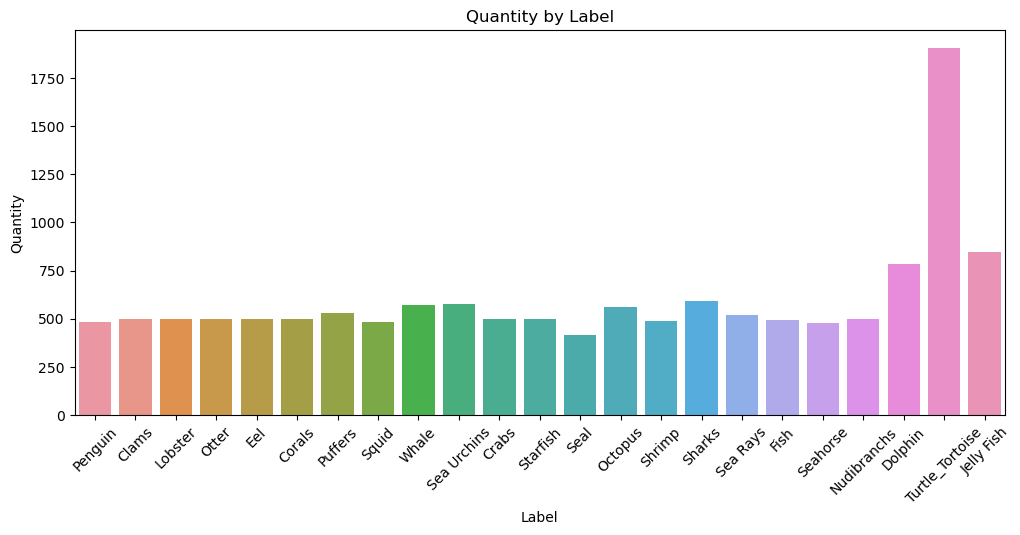

In [10]:
from prettytable import PrettyTable
src = os.listdir(dataset_path)
data = []
for lb in src:
    x = os.path.join(dataset_path, lb)
    y = os.listdir(x)
    data.append(len(y))
    table = PrettyTable()
    table.add_column("Labels", labels)
plt.figure(figsize=(12, 5))
sns.barplot(x=labels, y=data)
plt.title("Quantity by Label")
plt.xlabel("Label")
plt.ylabel("Quantity")
plt.xticks(rotation=45) 
plt.show()

In [11]:
def remove_directory(directory_path):
    for root, dirs, files in os.walk(directory_path, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)
    shutil.rmtree(directory_path)
directory_path = '/kaggle/working/sea-animals-image-datase'



In [12]:

output_path = '/kaggle/working/sea-animals-image-datase/'

if not os.path.exists(output_path):
    os.mkdir(os.path.join(output_path))

for label in labels:
    new_path = os.path.join(dataset_path, label)
    
    label_path = os.listdir(new_path)    
    
    ims = [i for i in label_path if i.endswith(".jpg")]
    
    random.shuffle(ims)
    split_size = 0.8
    train_len = int(len(ims) * split_size)
    train_ims = ims[:train_len]
    val_ims = ims[train_len:]
    
    # create train and val dirs
    train_path = os.path.join(output_path, "train")
    label_train_path = os.path.join(train_path, label)
    

    val_path = os.path.join(output_path, "val")
    label_val_path = os.path.join(val_path, label)
    
    if not os.path.exists(train_path):
        os.mkdir(train_path)
        
    if not os.path.exists(label_train_path):
        os.mkdir(label_train_path)
        
    if not os.path.exists(val_path):
        os.mkdir(val_path)  
    
    if not os.path.exists(label_val_path):
        os.mkdir(label_val_path)
    
    
    for im in train_ims:        
        shutil.copy(os.path.join(new_path, im), label_train_path)
    
    for im in val_ims:
        shutil.copy(os.path.join(new_path, im), label_val_path)

In [13]:
train_path = "/kaggle/working/sea-animals-image-datase/train"
TotalImages(train_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Starfish        │                396 │
├─────────────────┼────────────────────┤
│ Jelly Fish      │                673 │
├─────────────────┼────────────────────┤
│ Crabs           │                397 │
├─────────────────┼────────────────────┤
│ Otter           │                399 │
├─────────────────┼────────────────────┤
│ Corals          │                398 │
├─────────────────┼────────────────────┤
│ Seahorse        │                380 │
├─────────────────┼────────────────────┤
│ Seal            │                329 │
├─────────────────┼────────────────────┤
│ Sharks          │                469 │
├─────────────────┼────────────────────┤
│ Turtle_Tortoise │               1518 │
├─────────────────┼────────────────────┤
│ Fish            │                394 │
├─────────────────┼────────────────────┤
│ Puffers         │                424 │
├───────────────

In [14]:
val_path = "/kaggle/working/sea-animals-image-datase/val"
TotalImages(val_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Starfish        │                 99 │
├─────────────────┼────────────────────┤
│ Jelly Fish      │                169 │
├─────────────────┼────────────────────┤
│ Crabs           │                100 │
├─────────────────┼────────────────────┤
│ Otter           │                100 │
├─────────────────┼────────────────────┤
│ Corals          │                100 │
├─────────────────┼────────────────────┤
│ Seahorse        │                 96 │
├─────────────────┼────────────────────┤
│ Seal            │                 83 │
├─────────────────┼────────────────────┤
│ Sharks          │                118 │
├─────────────────┼────────────────────┤
│ Turtle_Tortoise │                380 │
├─────────────────┼────────────────────┤
│ Fish            │                 99 │
├─────────────────┼────────────────────┤
│ Puffers         │                106 │
├───────────────

In [15]:
TARGET_SIZE = (224, 224)

In [16]:
datagen = ImageDataGenerator(        
            width_shift_range=0.2,  
            height_shift_range=0.2,    
            brightness_range = (0.3, 0.9),
            zoom_range=0.2)

In [17]:
def Augmentation(path, capacity):
    for label in labels:
        if label == 'Turtle_Tortoise':
            continue
            
        image_directory = path + '/' + label + '/'
        SIZE = TARGET_SIZE[0]
        dataset = []

        print(image_directory)
        my_images = os.listdir(image_directory)
        for i, image_name in enumerate(my_images):    
            if ((image_name.split('.')[1] == 'jpg')):
                image = load_img(image_directory + image_name, target_size = TARGET_SIZE)
                image = img_to_array(image)
                dataset.append(image)

        x = np.array(dataset)
        i = 0
        for batch in datagen.flow(x, batch_size=16,
                                save_to_dir= train_path + '/' + label + '/',
                                save_prefix='aug',
                                save_format='jpg'):
            i += 1    
            if i > capacity:        
                break

In [18]:
Augmentation(train_path, 50)
Augmentation(val_path, 50)

/kaggle/working/sea-animals-image-datase/train/Penguin/
/kaggle/working/sea-animals-image-datase/train/Clams/
/kaggle/working/sea-animals-image-datase/train/Lobster/
/kaggle/working/sea-animals-image-datase/train/Otter/
/kaggle/working/sea-animals-image-datase/train/Eel/
/kaggle/working/sea-animals-image-datase/train/Corals/
/kaggle/working/sea-animals-image-datase/train/Puffers/
/kaggle/working/sea-animals-image-datase/train/Squid/
/kaggle/working/sea-animals-image-datase/train/Whale/
/kaggle/working/sea-animals-image-datase/train/Sea Urchins/
/kaggle/working/sea-animals-image-datase/train/Crabs/
/kaggle/working/sea-animals-image-datase/train/Starfish/
/kaggle/working/sea-animals-image-datase/train/Seal/
/kaggle/working/sea-animals-image-datase/train/Octopus/
/kaggle/working/sea-animals-image-datase/train/Shrimp/
/kaggle/working/sea-animals-image-datase/train/Sharks/
/kaggle/working/sea-animals-image-datase/train/Sea Rays/
/kaggle/working/sea-animals-image-datase/train/Fish/
/kaggle/w

In [19]:
TotalImages(train_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Starfish        │               1927 │
├─────────────────┼────────────────────┤
│ Jelly Fish      │               2261 │
├─────────────────┼────────────────────┤
│ Crabs           │               1938 │
├─────────────────┼────────────────────┤
│ Otter           │               1945 │
├─────────────────┼────────────────────┤
│ Corals          │               1940 │
├─────────────────┼────────────────────┤
│ Seahorse        │               2004 │
├─────────────────┼────────────────────┤
│ Seal            │               1843 │
├─────────────────┼────────────────────┤
│ Sharks          │               2030 │
├─────────────────┼────────────────────┤
│ Turtle_Tortoise │               1518 │
├─────────────────┼────────────────────┤
│ Fish            │               1923 │
├─────────────────┼────────────────────┤
│ Puffers         │               2005 │
├───────────────

In [20]:
TotalImages(val_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Starfish        │                 99 │
├─────────────────┼────────────────────┤
│ Jelly Fish      │                169 │
├─────────────────┼────────────────────┤
│ Crabs           │                100 │
├─────────────────┼────────────────────┤
│ Otter           │                100 │
├─────────────────┼────────────────────┤
│ Corals          │                100 │
├─────────────────┼────────────────────┤
│ Seahorse        │                 96 │
├─────────────────┼────────────────────┤
│ Seal            │                 83 │
├─────────────────┼────────────────────┤
│ Sharks          │                118 │
├─────────────────┼────────────────────┤
│ Turtle_Tortoise │                380 │
├─────────────────┼────────────────────┤
│ Fish            │                 99 │
├─────────────────┼────────────────────┤
│ Puffers         │                106 │
├───────────────

In [21]:
train_dataset_url = train_path
train_data_dir = pathlib.Path(train_dataset_url)

validation_dataset_url = val_path
validation_data_dir = pathlib.Path(validation_dataset_url)

img_height,img_width= TARGET_SIZE
batch_size=32

#Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 45135 files belonging to 23 classes.
Found 2743 files belonging to 23 classes.


In [22]:
def plot_images(dataset):
    plt.figure(figsize=(6,6))
    
    for images, labels in train_ds.take(1):
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    

In [25]:
model = Sequential([
    layers.Conv2D(64, (5,5), activation='relu', padding= 'valid', input_shape=(224,224,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(1024, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(labels), activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 128)     204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 128)      0

In [33]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [27]:
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True)

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20231214-044313
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-14 04:43:15.275577: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1411/1411 [==============================] - 181s 119ms/step - loss: 3.1439 - accuracy: 0.1382 - val_loss: 2.7126 - val_accuracy: 0.1600
Epoch 2/30
1411/1411 [==============================] - 164s 116ms/step - loss: 2.5057 - accuracy: 0.2236 - val_loss: 2.3424 - val_accuracy: 0.2618
Epoch 3/30
1411/1411 [==============================] - 163s 116ms/step - loss: 2.3389 - accuracy: 0.2726 - val_loss: 2.4428 - val_accuracy: 0.2483
Epoch 4/30
1411/1411 [==============================] - 164s 116ms/step - loss: 2.1863 - accuracy: 0.3150 - val_loss: 2.1383 - val_accuracy: 0.3332
Epoch 5/30
1411/1411 [==============================] - 165s 117ms/step - loss: 2.0476 - accuracy: 0.3579 - val_loss: 1.8767 - val_accuracy: 0.4123
Epoch 6/30
1411/1411 [==============================] - 165s 117ms/step - loss: 1.8936 - accuracy: 0.4080 - val_loss: 1.7175 - val_accuracy: 0.4626
Epoch 7/30
1411/1411 [==============================] - 164s 116ms/step - loss: 1.7177 - accuracy: 0.4575 - val_loss: 1.591

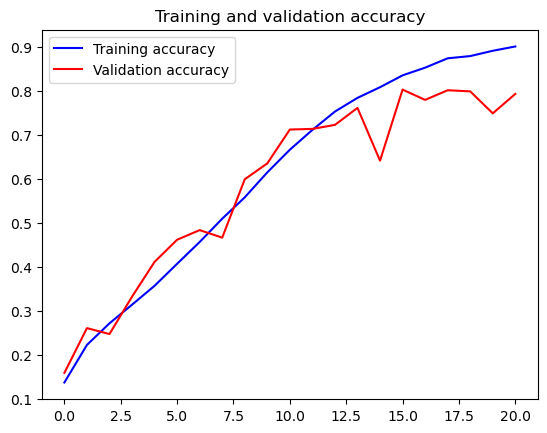

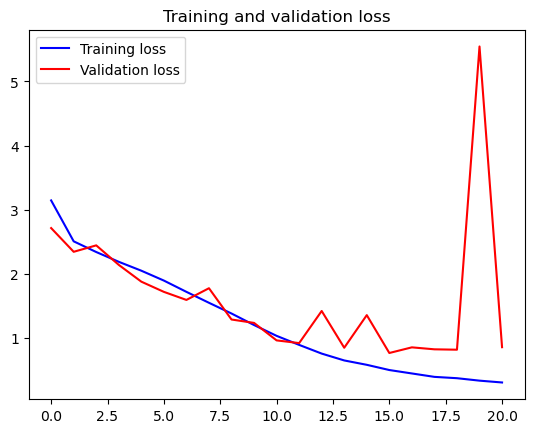

In [38]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()